Epoch 1, Loss: 1.7435534000396729, Accuracy: 23.533334732055664, Test Accuracy: 32.2645263671875
update layer
Epoch 20, Loss: 0.29485127329826355, Accuracy: 98.15555572509766, Test Accuracy: 98.99800109863281


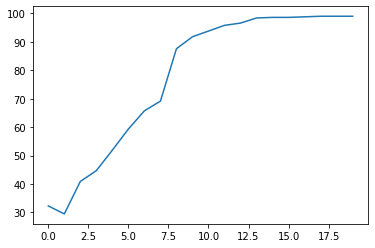

In [146]:
# hybrid model L_S 

# P 05
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from keras import backend as K


class LSLayer(tf.keras.layers.Layer):
    
    def __init__(self,  num_outputs_s, num_outputs_r, num_outputs_l, activation=sigmoid, wstd = 0.3, bstd = 0.5):
        super(LSLayer, self).__init__()
        self.num_outputs_l = num_outputs_l
        self.num_outputs_s = num_outputs_s 
        self.num_outputs_r = num_outputs_r
        self.num_outputs = num_outputs_l + num_outputs_s + num_outputs_r
        self.activation = activation
        self.wstd = wstd
        self.bstd = bstd
        
    def build(self, input_shape):  
        self.num_inputs = input_shape[-1]
        self.kernel = self.add_weight("kernel",
                                      shape=(int(input_shape[-1]),
                                             self.num_outputs), 
                                      initializer=tf.keras.initializers.RandomNormal(stddev=self.wstd),
                                     trainable=True)

        self.bias = self.add_weight("bias",
                                      shape=[self.num_outputs],
                                    initializer=tf.keras.initializers.RandomNormal(stddev=self.bstd),
                                   trainable=True)
        
    
    # F2 method LS layer
    def call(self, input):
        
        isp = input.shape
        In1 = tf.transpose(input)
        kernel_S, kernel_L  = tf.split(self.kernel,[ self.num_outputs_s + self.num_outputs_r, self.num_outputs_l ], axis = 1 )
        bias_S, bias_L  = tf.split(self.bias,[ self.num_outputs_s +  self.num_outputs_r, self.num_outputs_l ], axis = 0 )
        
        # case spherical
        
        s_shape  = self.num_outputs_s + self.num_outputs_r
        In2 = tf.stack([In1] * s_shape)
        InD = tf.transpose(In2)
        WD = tf.stack([kernel_S] * isp[0])
        ddd = WD - InD
        dd0 = tf.math.multiply(ddd, ddd)
        dd1 = tf.math.reduce_sum(dd0, axis =1)
        dd2 = tf.cast(dd1,tf.double)
        dd3 = tf.sqrt(dd2)
        d_r = tf.cast(dd3,tf.float32)
        d_R = tf.abs(bias_S)
        d_rR = tf.math.divide_no_nan(d_r,d_R)
        d_x0 = tf.ones(d_rR.shape) - d_rR
        result_S = tf.math.scalar_mul(6,d_x0)
        result_S = sigmoid(result_S)
        
        # case linear

        d_1 = tf.stack([bias_L] * isp[0])
        result_L = tf.matmul(input, kernel_L) + d_1 
        result_L = relu(result_L)

        #case empty, merge
        
        '''
        #print (self.num_outputs_r)
        if self.num_outputs_r > 0:
            r_S, _ = tf.split (result_S,[self.num_outputs_s, self.num_outputs_r],axis=1 )
            r_1 = np.zeros((result_S.shape[0],self.num_outputs_r))
            result_R = tf.cast(tf.constant(r_1),tf.float32)
            result = tf.concat([r_S, result_R, result_L],axis=1)            
            #print (self.num_outputs_s, self.num_outputs_r)
            #print ("result_S", result_S)
            #print ("result_L", result_L)
            #print ("result", result)
        else:
            result = tf.concat([result_S, result_L],axis=1)        
        '''
        
        result = tf.concat([result_S, result_L],axis=1)        
        
        return result
    

class NN_Model(Model):
    
    def __init__(self,c,hs,hr,hl):
        super(NN_Model, self).__init__()
        self.d1 = LSLayer(hs,hr,hl)
        self.d2 = Dense(c)

    def call(self, x):
        x = self.d1(x)
        #print ("call benn:",x, tf.math.reduce_sum(x))
        return self.d2(x)
        


@tf.function
def train_step(datas, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(datas, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(datas, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    predictions = model(datas, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    
    
def update_NN_model (model, train_ds,optimizer):

    rdb = 0
    odb = 0
    #N = min(5, model.d1.num_outputs_r)   # number of new SSN nodes
    N = model.d1.num_outputs_r   # number of new SSN nodes
    
    if N <= 0:
        return
    
    # k-means
    
    baditems = []
    for datas, labels in train_ds:
        predictions = model(datas, training=False)
        for i in range(datas.shape[0]):
            #print (datas.numpy()[i], predictions.numpy()[i], np.argmax(predictions.numpy()[i]), labels.numpy()[i],np.argmax(labels.numpy()[i]))
            if np.argmax(predictions.numpy()[i]) != np.argmax(labels.numpy()[i]):
                rdb = rdb + 1
                baditems.append(datas.numpy()[i])
            odb = odb + 1        
    #print ("pontossag:",(odb-rdb)/odb, len(baditems))
    N = min(N, len(baditems))
    if N == 0:
        return
    inds = random.sample(range(len(baditems)), N)
    
    print ("update layer")
    #print (baditems)
    centers = KMeans(n_clusters=N).fit(baditems).cluster_centers_
    #print ("centers:")
    #print (centers)
    neww = np.zeros((model.d1.num_inputs,N))
    for i in range(N):
        for j in range(model.d1.num_inputs):
            neww[j,i] = centers[i][j]
    #print ("neww")
    #print (neww)
            
    newb = np.zeros((N))
    for i in range(N):
        newb[i] = random.random()*model.d1.bstd
 
    xu = model.d1.get_weights()
    
    for j in range(N):
        for i in range(xu[0].shape[0]):
            xu[0][i][model.d1.num_outputs_s + j] = neww[i,j]
        xu[1][j] = newb[j]
            
    model.d1.set_weights(xu )
    
    model.d1.num_outputs_s = model.d1.num_outputs_s + N
    model.d1.num_outputs_r = model.d1.num_outputs_r - N

    #optimizer = tf.keras.optimizers.Adam
    #for var in optimizer.variables():
    #    var.assign(tf.zeros_like(var))
    
C= 6
L= 50
N= 5000
M= 6
HS = 45
HR = 15
HL = 0
EPOCHS = 20
Eupd = 6
B = 32

# Create an instance of the model
model = NN_Model(C,HS,HR,HL)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

(x_train,y_train,x_test,y_test) = gen_data_array(C, L, N, M)
#print (x_train[:2])
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).batch(B)
#print (train_ds)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(B)

    


X = []
Y = []
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch

    if epoch > 1:
        xu2 = model.d1.get_weights()
        #print ("WW",epoch, "WW", xu2[0])

    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for datas, labels in train_ds:
        train_step(datas, labels)
        
                
    for test_datas, test_labels in test_ds:
        #print ("test_data_shape", test_datas.shape)
        predictions = model(test_datas, training=False)
        #print ("ttttttttttttttttttt")
        #for i in range(test_datas.shape[0]):
        #    print (predictions.numpy()[i], test_labels.numpy()[i])
        test_step(test_datas, test_labels)
        
    if epoch == Eupd :
        update_NN_model (model, train_ds, optimizer)
        
        
    X.append(epoch)
    Y.append(test_accuracy.result() * 100)
    if epoch % 20 == 0:
        print(
            f'Epoch {epoch + 1}, '
            f'Loss: {train_loss.result()}, '
            f'Accuracy: {train_accuracy.result() * 100}, '
            f'Test Accuracy: {test_accuracy.result() * 100}'
          )    
        #print(model.d1.bias.numpy())


print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )    

    
plt.plot(X, Y,label="Accuracy curve")



In [147]:
import statistics 

x = [100,86,91,81,96,97,88,86,93,99]
print (sum(x)/len(x), statistics.stdev(x))

91.7 6.3604681868204915


In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_blobs
import numpy as np
import random 


tf.enable_eager_execution()


def gen_cluster_data_list(Cv, Lv, Nv, Mv):
    Tr = []
    Ts = []
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    X, y = make_blobs(n_samples=N, centers=L, n_features=M,cluster_std=.5, random_state=11)
    cmap = []
    for _ in range(L):
        cmap.append(random.randint(0,C-1))
    cols = []
    for i in range(N):
        cols.append(cmap[y[i]])

    for i in range(int(0.9*N)):
        row = [X[i,j] for j in range(M)]
        row.append(cols[i])
        Tr.append(row)
    
    for i in range(int(0.9*N)+1,N):
        row = [X[i,j] for j in range(M)]
        row.append(cols[i])
        Ts.append(row)
        
    return (Tr, Ts)

def normalize (train):
    mx = []
    mn = []
    for i in range(len(train[0])-1):
        mx.append(max([x[i] for x in train ]))
        mn.append(min([x[i] for x in train ]))
    for row in train:
        for i in range(len(row)-1):
            row[i] = (row[i] - mn[i]) / (mx[i] - mn[i]) 
    return train


def gen_data_array(Cv, Lv, Nv, Mv):
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    (T1,T2)  = gen_cluster_data_list(C, L, N, M)

    T = normalize(T1)
    N = len(T)
    x2_train = np.zeros((N,M),dtype='float32')
    y2_train = np.zeros((N,C))
    for i in range(N):
        row = T[i]
        for j in range(M):
            x2_train[i,j] = row[j]
        y2_train[i,row[-1]] = 1

    Ts = normalize(T2)
    Ns = len(Ts)
    x2_test = np.zeros((Ns,M),dtype='float32')
    y2_test = np.zeros((Ns,C))
    for i in range(Ns):
        row = Ts[i]
        for j in range(M):
            x2_test[i,j] = row[j]
        y2_test[i, row[-1]] = 1
        
    return (x2_train,y2_train, x2_test, y2_test)

def gen_data_array_s(Cv, Lv, Nv, Mv):
    C = Cv  # number of categories
    L = Lv   # number of centers
    N = Nv  # number of elements
    M = Mv  # number of dimensions
    (T1,T2)  = gen_cluster_data_list(C, L, N, M)

    T = normalize(T1)
    N = len(T)
    x2_train = np.zeros((N,M),dtype='float32')
    y2_train = np.zeros((N,1))
    for i in range(N):
        row = T[i]
        for j in range(M):
            x2_train[i,j] = row[j]
        y2_train[i] = row[-1]

    Ts = normalize(T2)
    Ns = len(Ts)
    x2_test = np.zeros((Ns,M),dtype='float32')
    y2_test = np.zeros((Ns,1))
    for i in range(Ns):
        row = Ts[i]
        for j in range(M):
            x2_test[i,j] = row[j]
        y2_test[i] = row[-1]
        
    return (x2_train,y2_train, x2_test, y2_test)



In [12]:
print (3**4)

81
